In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import heapq
import itertools
import copy
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import time
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from matplotlib.backends.backend_pdf import PdfPages

/home/hoge/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed()

In [3]:
pretrained_model = "googlefonts.pth" #事前学習済みMNISTモデル(重みパラメータ)
use_cuda = True

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 26)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# MNISTのTest datasetと dataloaderの定義
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,), (0.5,))
#             ])), 
#         batch_size=1, shuffle=False)

# 使うデバイス（CPUかGPUか）の定義
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# ネットワークの初期化
model = Net().to(device)
print(model)
# 訓練済みモデルのロード
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))


# モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
model.eval()

CUDA Available:  True
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

In [5]:
# sum_resistance1 = 0
# sum_resistance2 = 0
# for i in range(26):
#     count = 0
#     l1 = os.listdir("../normalPGD_googlefonts/resistance/" + chr(i + 65))
#     l2 = os.listdir("../normalPGD_GAN+reg_25_g1_r2/resistance/" + chr(i + 65))
#     count_list1 = []
#     count_list2 = []
#     for j in l1:
#         for k in range(sum(os.path.isfile(os.path.join("../normalPGD_googlefonts/resistance/" + chr(i + 65) + "/" + j, name)) for name in os.listdir("../normalPGD_googlefonts/resistance/" + chr(i + 65) + "/" + j))):
#             count_list1.append(int(j))
#         #     count += 1
#         #     if count == 500:
#         #         break
#         # if count == 500:
#         #     break
#     count = 0
#     for j in l2:
#         for k in range(sum(os.path.isfile(os.path.join("../normalPGD_GAN+reg_25_g1_r2/resistance/" + chr(i + 65) + "/" + j, name)) for name in os.listdir("../normalPGD_GAN+reg_25_g1_r2/resistance/" + chr(i + 65) + "/" + j))):
#             count_list2.append(int(j))
#         #     count += 1
#         #     if count == 500:
#         #         break
#         # if count == 500:
#         #     break
#     count_ndarray1 = np.array(count_list1)
#     print(np.mean(count_ndarray1))
#     sum_resistance1 += np.mean(count_ndarray1)
#     count_ndarray2 = np.array(count_list2)
#     print(np.mean(count_ndarray2))
#     sum_resistance2 += np.mean(count_ndarray2)
#     # for a in range(1000, 0, -1):
#     #     if np.count_nonzero(count_ndarray >= a) >= 200:
#     #         print(chr(i + 65) + ":{}:{}".format(a, np.count_nonzero(count_ndarray >= a)))
#     #         break
#     plt.hist(count_ndarray1, range=(0, 30), bins = 30, alpha = 0.5)
#     # plt.hist(count_ndarray2, range=(0, 30), bins = 30, alpha = 0.5)
#     plt.xlabel("step")
#     plt.ylabel("samples")
#     plt.title(chr(i + 65))
#     # plt.savefig("../normalPGD_GAN+reg_25_g1_r2/resistance/" + chr(i + 65) + "_hist.png", facecolor="white")
#     plt.show()
# print(sum_resistance1 / 26)
# print(sum_resistance2 / 26)

In [6]:
class ImageTransform():
    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
        transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
mean = (0.5,)
std = (0.5,)
images_test = ImageFolder( "../GoogleFonts/test", transform = ImageTransform(mean, std))
batch_size = 1
test_loader = DataLoader(images_test, batch_size = batch_size, shuffle = False, drop_last=True)
# 精度カウンター
correct_list = [0] * 26
success = 0
# count = 0
count = [0] * 26

adv_examples = []
# i=0

# テスト用データセット内の全てのサンプルをループします
for data, target in tqdm(test_loader, total = len(test_loader)):
    # i+=1
    # if i==150:
    #     break
    # データとラベルをデバイス（CPUもしくはGPU）に送信します
    data, target = data.to(device), target.type(torch.LongTensor).to(device)
    # テンソルの requires_grad 属性を設定します。攻撃者にとっては重要な設定です。

    data.requires_grad = True

    # データをモデルに順伝播させます
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] # 最大の確率のインデックスを取得します。

    # 最初から予測が間違っている場合、攻撃する必要がないため次のイテレーションに進みます。
    
    count[target.item()] += 1
    if init_pred.item() == target.item():
        correct_list[target.item()] += 1

result = []
for i in range(26):
    result.append(correct_list[i]/count[i] * 100)

100%|██████████| 30862/30862 [01:22<00:00, 374.79it/s]


In [7]:
print(result)

[94.52401010951979, 94.52401010951979, 96.29317607413648, 95.87194608256108, 96.04043807919123, 97.21988205560235, 96.29317607413648, 96.46166807076663, 93.42881213142375, 93.34456613310867, 95.61920808761583, 96.04043807919123, 95.45071609098568, 95.11373209772536, 96.96714406065712, 96.88289806234204, 95.02948609941028, 95.19797809604043, 97.21988205560235, 96.71440606571188, 96.04043807919123, 94.60825610783488, 96.54591406908172, 97.0513900589722, 94.52401010951979, 96.6301600673968]


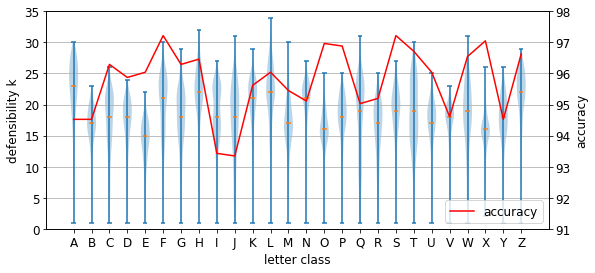

In [35]:
plt.rcParams["font.size"] = 12
all_data = []
for i in range(26):
    l = os.listdir("../normalPGD_googlefonts/resistance/" + chr(i + 65))
    count_list = []
    for j in l:
        for k in range(sum(os.path.isfile(os.path.join("../normalPGD_googlefonts/resistance/" + chr(i + 65) + "/" + j, name)) for name in os.listdir("../normalPGD_googlefonts/resistance/" + chr(i + 65) + "/" + j))):
            count_list.append(int(j))
    count_ndarray = np.array(count_list)
    all_data.append(count_ndarray)

labels = [chr(i + 65) for i in range(26)]
fig, ax = plt.subplots(figsize=(9, 4))
ax2 = ax.twinx()
showmedians = ax.violinplot(all_data, showmedians=True)
showmedians['cmedians'].set_color('C1')
ax2.plot([i + 1 for i in range(26)], result, color="red")

ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
ax.set_xlabel('letter class')
ax.set_ylabel('defensibility k')
# plt.tick_params(labelsize=25)
ax.grid(axis="y")
ax.set_ylim(0, 35)
# ax.legend(['Defensibility'], loc='center right')

ax2.set_ylabel('accuracy')
ax2.set_ylim(91, 98)
ax2.legend(["accuracy"], loc="lower right")

# plt.savefig("violin.png", facecolor="white", bbox_inches='tight', pad_inches=0.1)
plt.show()
pp = PdfPages('violin.pdf')

# save figure
pp.savefig(fig, bbox_inches='tight', pad_inches=0)

# close file
pp.close()